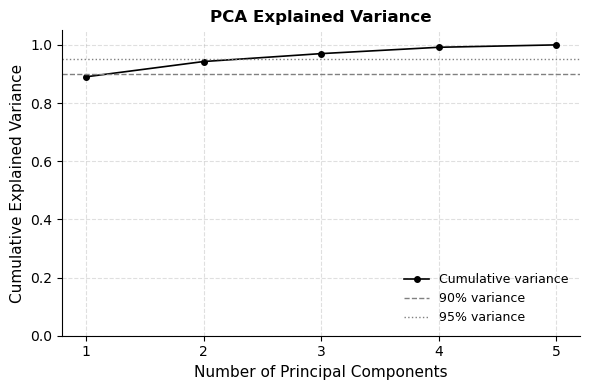

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

df = pd.read_csv("cpgs_with_Hypo_ID.csv", sep=",")

frac_cols = [col for col in df.columns if col.endswith('_frac')]

X = df[frac_cols].dropna()
# Assuming you have a dataframe 'X' with your features (e.g., methylation fractions)
# You can replace this with your actual DataFrame
# Example: X = df[frac_cols].dropna()

pca = PCA()
X_pca = pca.fit_transform(X)
explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()

# === Plot: Explained variance ===
fig, ax = plt.subplots(figsize=(6, 4))  # Use 6x4 inches for publication-size plot

ax.plot(
    range(1, len(cumulative_var) + 1),
    cumulative_var,
    marker='o',
    markersize=4,
    linestyle='-',
    color='black',
    linewidth=1.2,
    label='Cumulative variance'
)

# Horizontal reference lines
ax.axhline(0.90, color='grey', linestyle='--', linewidth=1, label='90% variance')
ax.axhline(0.95, color='grey', linestyle=':', linewidth=1, label='95% variance')

# Axis styling
ax.set_xlabel('Number of Principal Components', fontsize=11)
ax.set_ylabel('Cumulative Explained Variance', fontsize=11)
ax.set_title('PCA Explained Variance', fontsize=12, weight='bold')
ax.set_xticks(range(1, len(cumulative_var) + 1))
ax.set_ylim(0, 1.05)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', alpha=0.4)
ax.tick_params(axis='both', labelsize=10)

# Legend
ax.legend(frameon=False, fontsize=9, loc='lower right')

# === Save figure ===
plt.tight_layout()
plt.savefig("pca_variance_hypo.pdf", format='pdf', bbox_inches='tight')
plt.savefig("pca_variance_hypo.svg", format='svg', bbox_inches='tight')
plt.show()

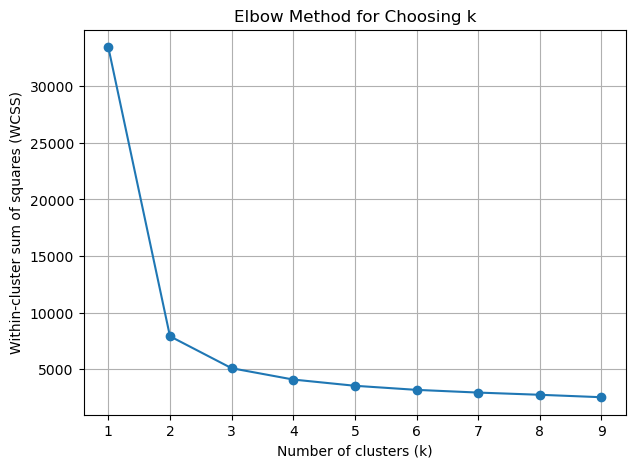

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
k_values = range(1, 10)  # try k from 1 to 9

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)  # inertia_ is WCSS

plt.figure(figsize=(7,5))
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Elbow Method for Choosing k')
plt.grid(True)
plt.savefig("elbow_plot_hypo.pdf", format='pdf', bbox_inches='tight')
plt.savefig("elbow_plot_hypo.svg", format='svg', bbox_inches='tight')
plt.show()

/data/cephfs-1/home/users/cama15_c/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/data/cephfs-1/home/users/cama15_c/.local/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


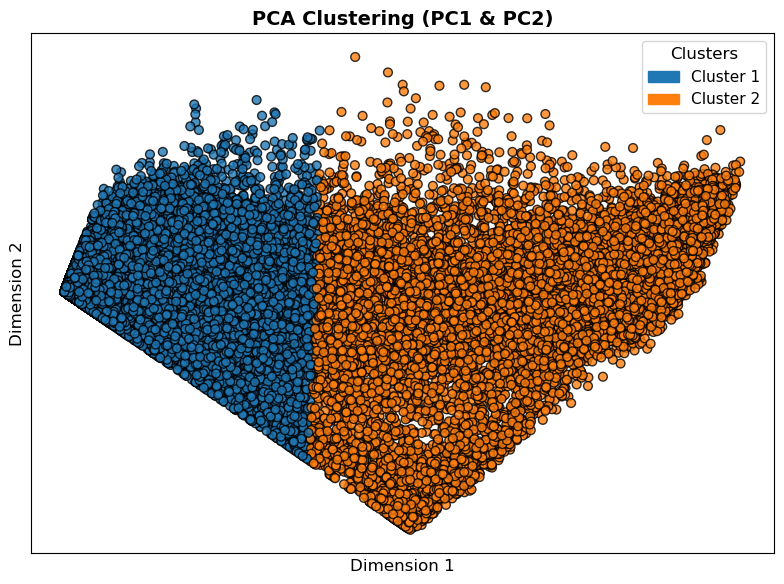

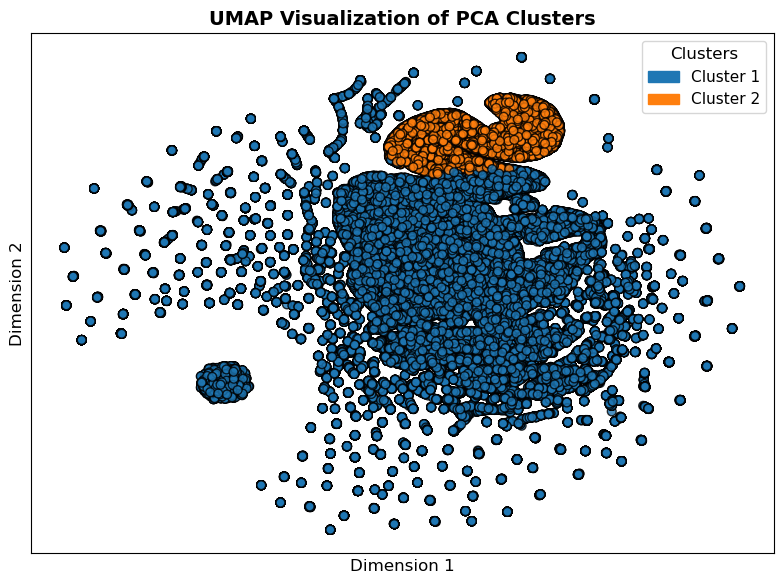

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap.umap_ as umap

# --- Load data ---
df = pd.read_csv("cpgs_with_Hypo_ID.csv", sep=",")

# --- Filter rows with non-null IR_ID ---
df_me = df[df['Hypo_ID'].notna()]

# --- Select methylation fraction columns ---
frac_cols = ['Naive_frac', 'Formative_frac', 'Primed_frac', 'Formative_Neuron_frac', 'Primed_Neuron_frac']

# --- Extract methylation fractions for each CpG site (each row) ---
X = df_me[frac_cols]

#drop nans
X = X.dropna()

# --- PCA ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.values)

# --- KMeans clustering (2 clusters) ---
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)
clusters_named = clusters + 1  # clusters labeled 1,2,3,4

# --- UMAP on PCA components ---
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)

# --- Plotting style ---
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

def plot_clusters(X, labels, title, filename=None):
    plt.figure(figsize=(8, 6))
    colors = ['#1f77b4', '#ff7f0e']  # blue, orange, green, red
    label_colors = [colors[label - 1] for label in labels]
    
    plt.scatter(X[:, 0], X[:, 1], c=label_colors, s=40, alpha=0.8, edgecolor='k')
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    patches = [mpatches.Patch(color=colors[i], label=f'Cluster {i+1}') for i in range(2)]
    plt.legend(handles=patches, title='Clusters', fontsize=11, title_fontsize=12, loc='best')
    plt.tight_layout()
    
    if filename:
        plt.savefig(f"{filename}.pdf", bbox_inches='tight')
        plt.savefig(f"{filename}.svg", bbox_inches='tight')
    plt.show()

# --- Plot PCA scatter ---
plot_clusters(X_pca[:, :2], clusters_named, "PCA Clustering (PC1 & PC2)", filename="PCA_clustering")

# --- Plot UMAP scatter ---
plot_clusters(X_umap, clusters_named, "UMAP Visualization of PCA Clusters", filename="UMAP_clustering")


In [10]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap.umap_ as umap

# Load data
df = pd.read_csv("cpgs_with_Hypo_ID.csv", sep=",")

# Columns for methylation fractions
frac_cols = ['Naive_frac', 'Formative_frac', 'Primed_frac', 'Formative_Neuron_frac', 'Primed_Neuron_frac']

#filter out NaNs, keep zeros
df_me = df[df['Hypo_ID'].notna()].copy()
df_me = df_me[df_me[frac_cols].notna().all(axis=1)]

# Extract methylation fractions matrix
X = df_me[frac_cols].values

# PCA (3 components)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# KMeans clustering on PCA components (adjust n_clusters as needed)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)
clusters_named = clusters + 1  # label clusters starting at 1

# Add cluster labels back to df_me
df_me['Cluster'] = clusters_named

# Select only desired columns for output
out_cols = ['Chromosome', 'Start', 'End', 'Hypo_ID', 'Cluster']
df_out = df_me[out_cols]

# Sort by Cluster before saving
df_out_sorted = df_out.sort_values(by='Cluster')

# Save sorted CSV
df_out_sorted.to_csv("cpgs_cluster_regions_hypo.csv", index=False)

In [11]:
import pyranges as pr
import gzip

# Load CpGs
df_cpgs = pd.read_csv("cpgs_cluster_regions_hypo.csv")
df_cpgs = df_cpgs.rename(columns={"Chr": "Chromosome"})
df_cpgs["Chromosome"] = df_cpgs["Chromosome"].astype(str)
df_cpgs["Start"] = df_cpgs["Start"].astype(int)
df_cpgs["End"] = df_cpgs["End"].astype(int)
gr_cpgs = pr.PyRanges(df_cpgs[["Chromosome", "Start", "End"]])

# Annotate overlaps with BED files
bed_files = {
    "TSS": "gencode_v48_TSSs.bed",
    "Promoter": "gencode_v48_promoters.bed",
    "GeneBody": "gencode_v48_gene_bodies.bed",
    "Exon": "gencode_v48_exons.bed",
    "Intron": "gencode_v48_introns.bed"
}

for feature_name, bed_file in bed_files.items():
    gr_feature = pr.read_bed(bed_file)
    
    # Expand TSS by ±1000 bp
    if feature_name == "TSS":
        df_feat = gr_feature.df.copy()
        df_feat["Start"] = df_feat["Start"] - 1000
        df_feat["End"] = df_feat["End"] + 1000
        gr_feature = pr.PyRanges(df_feat)
    
    overlaps = gr_cpgs.overlap(gr_feature)
    overlapped_intervals = set(zip(overlaps.df["Chromosome"], overlaps.df["Start"], overlaps.df["End"]))
    
    def check_overlap(row):
        return (row["Chromosome"], row["Start"], row["End"]) in overlapped_intervals
    
    df_cpgs[f"Overlaps_{feature_name}"] = df_cpgs.apply(check_overlap, axis=1)

# Annotate GeneBody_Type and Gene_Name based on GTF
gtf_file = "gencode.v48.basic.annotation.gtf.gz"
gtf_cols = ["Chromosome", "Source", "Feature", "Start", "End", "Score", "Strand", "Frame", "Attributes"]

with gzip.open(gtf_file, "rt") as f:
    gtf = pd.read_csv(f, sep="\t", comment="#", names=gtf_cols)

genes = gtf[gtf["Feature"] == "gene"].copy()
genes["gene_type"] = genes["Attributes"].str.extract(r'gene_type "([^"]+)"')
genes["gene_id"] = genes["Attributes"].str.extract(r'gene_id "([^"]+)"')
genes["gene_name"] = genes["Attributes"].str.extract(r'gene_name "([^"]+)"')

target_types = ["protein_coding", "lncRNA", "pseudogene", "miRNA"]
genes_filtered = genes[genes["gene_type"].isin(target_types)].copy()

gr_genes_filtered = pr.PyRanges(genes_filtered[["Chromosome", "Start", "End", "gene_type", "gene_id", "gene_name"]])
gr_gene_overlap = gr_cpgs.join(gr_genes_filtered)

overlap_df = gr_gene_overlap.df[["Chromosome", "Start", "End", "gene_type", "gene_name"]].drop_duplicates()
overlap_df.rename(columns={"gene_type": "GeneBody_Type", "gene_name": "Gene_Name"}, inplace=True)

df_cpgs = df_cpgs.merge(overlap_df, on=["Chromosome", "Start", "End"], how="left")
df_cpgs["GeneBody_Type"] = df_cpgs["GeneBody_Type"].fillna("None")
df_cpgs["Gene_Name"] = df_cpgs["Gene_Name"].fillna("None")

# Annotate distances to retrotransposons
rmsk_file = "rmsk.txt.gz"
rmsk_cols = ["bin", "swScore", "milliDiv", "milliDel", "milliIns",
             "genoName", "genoStart", "genoEnd", "genoLeft",
             "strand", "repName", "repClass", "repFamily",
             "repStart", "repEnd", "repLeft", "id"]

rmsk = pd.read_csv(rmsk_file, sep="\t", names=rmsk_cols, header=None, compression='gzip')

repeat_types = {
    "Alu": rmsk[rmsk["repName"].str.contains("Alu")],
    "L1": rmsk[rmsk["repName"].str.contains("L1")],
    "SVA": rmsk[rmsk["repName"].str.contains("SVA")],
    "MIR": rmsk[rmsk["repName"].str.contains("MIR")],
    "LTR": rmsk[rmsk["repClass"].str.contains("LTR")]
}

pr_repeats = {}
for rep_type, df_rep in repeat_types.items():
    df_rep_rename = df_rep.rename(columns={"genoName": "Chromosome",
                                           "genoStart": "Start",
                                           "genoEnd": "End"})
    pr_repeats[rep_type] = pr.PyRanges(df_rep_rename[["Chromosome", "Start", "End"]])

for rep_type, gr_rep in pr_repeats.items():
    nearest = gr_cpgs.nearest(gr_rep)
    df_dist = nearest.df[["Chromosome", "Start", "End", "Distance"]].rename(columns={"Distance": f"Dist_to_{rep_type}"})
    df_cpgs = df_cpgs.merge(df_dist, on=["Chromosome", "Start", "End"], how="left")
    df_cpgs[f"Near_{rep_type}"] = df_cpgs[f"Dist_to_{rep_type}"].fillna(10**9) <= 1000

# Save final annotated CpG dataframe
df_cpgs = df_cpgs.sort_values(by="Cluster")
df_cpgs.to_csv("annotated_hypo_clusters.csv", index=False)

/data/cephfs-1/home/users/cama15_c/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/data/cephfs-1/home/users/cama15_c/.local/lib/python3.11/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


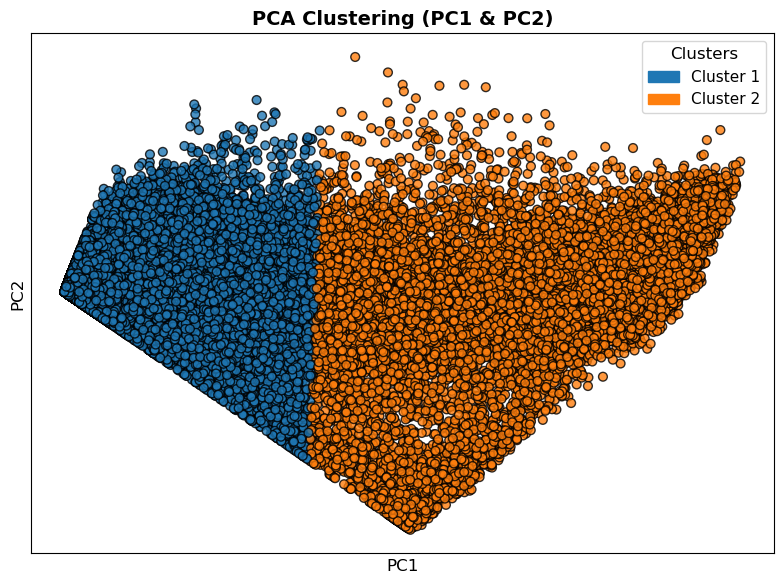

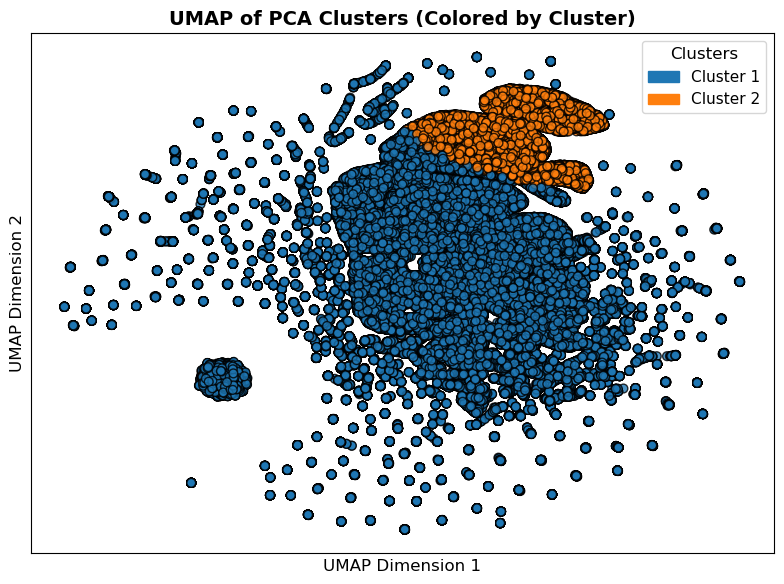

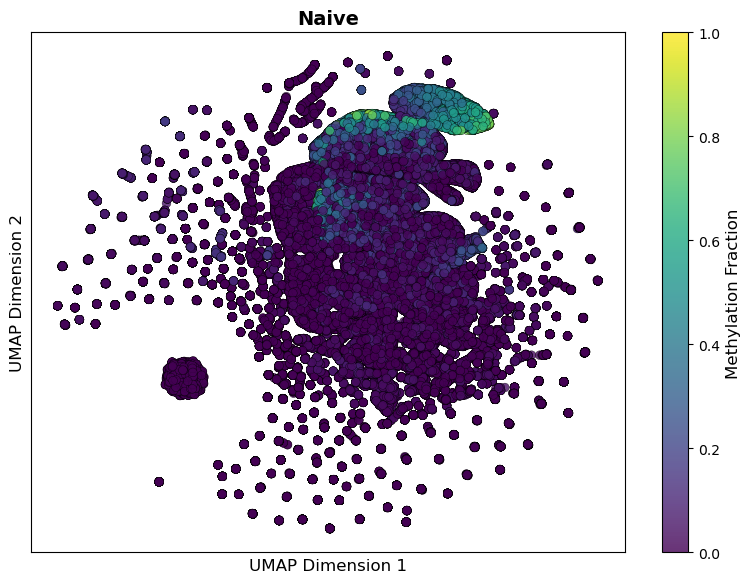

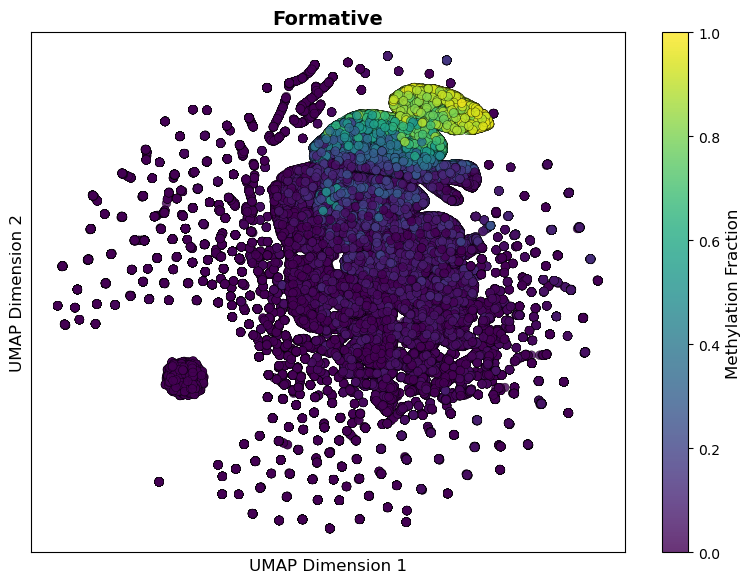

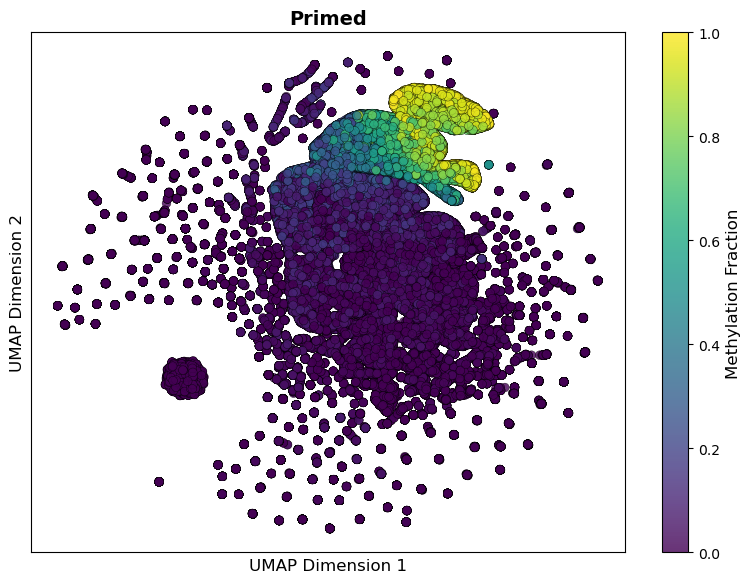

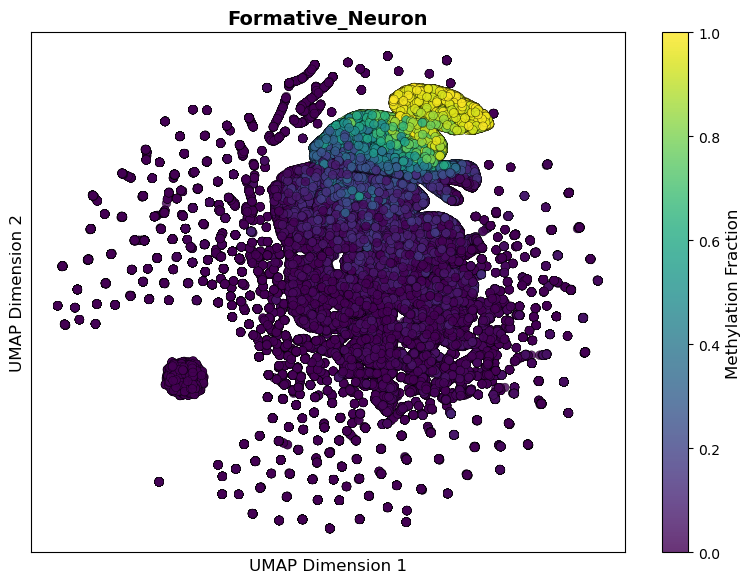

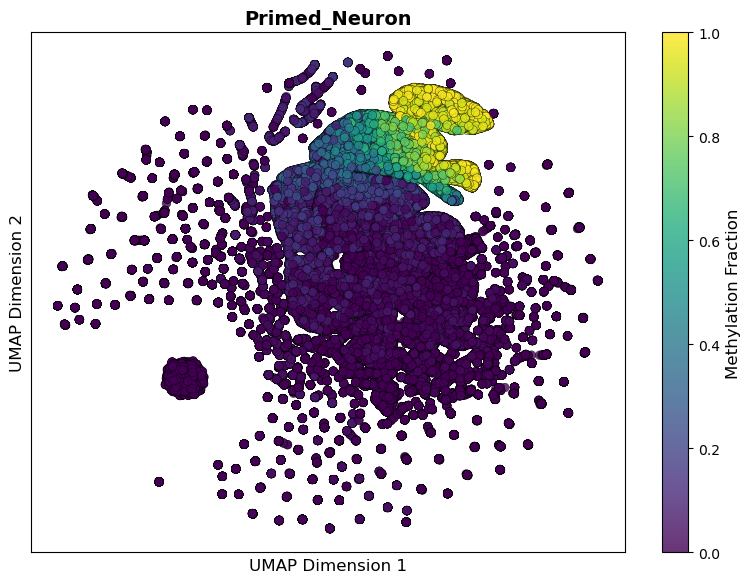

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap.umap_ as umap

# --- Load data ---
df = pd.read_csv("cpgs_with_Hypo_ID.csv", sep=",")

# --- Filter rows with non-null Hypo_ID ---
df_me = df[df['Hypo_ID'].notna()]

# --- Select methylation fraction columns ---
frac_cols = ['Naive_frac', 'Formative_frac', 'Primed_frac', 'Formative_Neuron_frac', 'Primed_Neuron_frac']

# --- Drop rows with any NaN ---
X = df_me[frac_cols].dropna()

# --- Keep corresponding rows in original dataframe ---
df_me_filtered = df_me.loc[X.index].reset_index(drop=True)
X = X.reset_index(drop=True)

# --- PCA on methylation fractions ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.values)

# --- KMeans clustering (2 clusters) ---
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)
cluster_labels = clusters + 1  # Make it 1 and 2 for nicer plotting

# --- UMAP on PCA components ---
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)

# --- Plotting style ---
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})

# --- Define consistent cluster colors ---
colors = ['#1f77b4', '#ff7f0e']  # blue and orange
label_colors = [colors[label - 1] for label in cluster_labels]

# --- PCA Clustering Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=label_colors, s=40, alpha=0.8, edgecolor='k')
plt.title("PCA Clustering (PC1 & PC2)", fontsize=14, weight='bold')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.xticks([])
plt.yticks([])
plt.grid(False)
patches = [mpatches.Patch(color=colors[i], label=f'Cluster {i+1}') for i in range(2)]
plt.legend(handles=patches, title='Clusters', fontsize=11, title_fontsize=12, loc='best')
plt.tight_layout()
plt.savefig("PCA_clustering_by_cluster.pdf", bbox_inches='tight')
plt.savefig("PCA_clustering_by_cluster.svg", bbox_inches='tight')
plt.show()

# --- UMAP Clustering Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=label_colors, s=40, alpha=0.8, edgecolor='k')
plt.title("UMAP of PCA Clusters (Colored by Cluster)", fontsize=14, weight='bold')
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.legend(handles=patches, title='Clusters', fontsize=11, title_fontsize=12, loc='best')
plt.tight_layout()
plt.savefig("UMAP_clustering_by_cluster.pdf", bbox_inches='tight')
plt.savefig("UMAP_clustering_by_cluster.svg", bbox_inches='tight')
plt.show()

# --- Per-sample methylation plots on UMAP layout ---
for sample_col in frac_cols:
    methylation_vals = df_me_filtered[sample_col].values

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(
        X_umap[:, 0],
        X_umap[:, 1],
        c=methylation_vals,
        cmap='viridis',
        s=40,
        alpha=0.8,
        edgecolor='k',
        linewidth=0.3
    )

    sample_name = sample_col.replace('_frac', '')
    plt.title(f"{sample_name}", fontsize=14, weight='bold')
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.colorbar(sc, label='Methylation Fraction')

    plt.tight_layout()
    plt.savefig(f"UMAP_PCAclusters_{sample_name}.pdf", bbox_inches='tight')
    plt.savefig(f"UMAP_PCAclusters_{sample_name}.svg", bbox_inches='tight')
    plt.show()

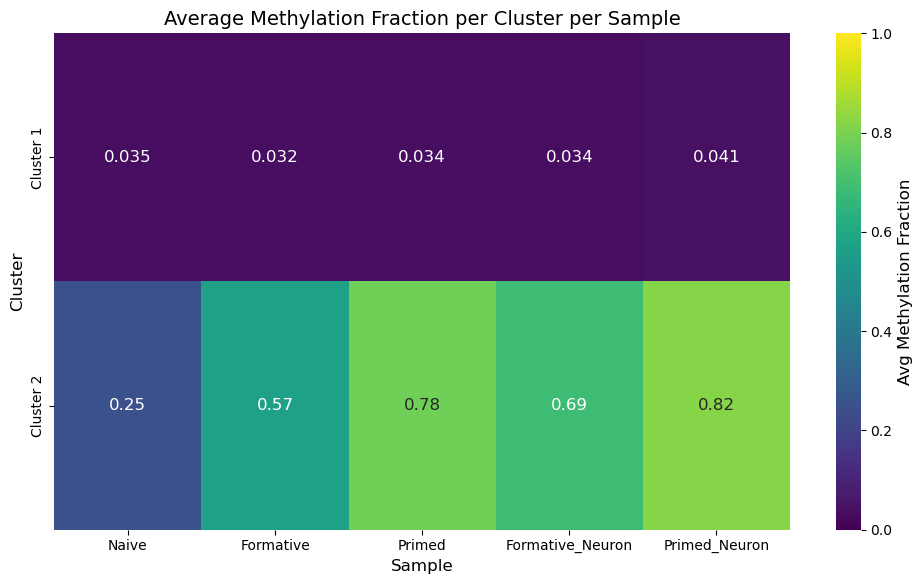

In [16]:
import seaborn as sns
# Create DataFrame for clusters aligned with X index
clusters_df = pd.DataFrame({'Cluster': clusters_named}, index=X.index)

# Combine methylation data with cluster labels
df_combined = pd.concat([X, clusters_df], axis=1)

# Group by cluster, calculate mean methylation fraction per sample
cluster_means = df_combined.groupby('Cluster').mean()

# Rename index and columns for nicer labels
cluster_means.index = [f'Cluster {i}' for i in cluster_means.index]
cluster_means_renamed = cluster_means.rename(columns=lambda x: x.replace('_frac', ''))

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    cluster_means_renamed,
    annot=True,
    cmap='viridis',
    cbar_kws={'label': 'Avg Methylation Fraction'},
    vmin=0,
    vmax=1
)
plt.title('Average Methylation Fraction per Cluster per Sample')
plt.ylabel('Cluster')
plt.xlabel('Sample')
plt.tight_layout()
plt.savefig("hypo_clusters_heatmap.pdf", bbox_inches='tight')
plt.savefig("hypo_clusters_heatmap.svg", bbox_inches='tight')
plt.show()

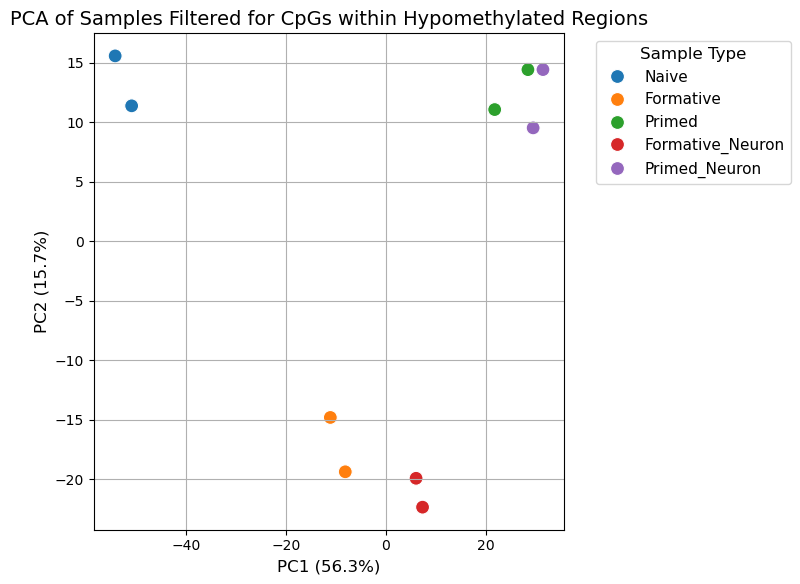

In [17]:
df = pd.read_csv('cpgs_within_hypo_regions.csv', sep=',')

# Extract fraction columns
frac_cols = [col for col in df.columns if col.endswith('_frac')]

frac_data = df[frac_cols]

# Get sample names like 'Naive_1', 'Primed_1', etc.
sample_names = [col.replace('_frac', '') for col in frac_cols]

# Transpose: samples as rows
frac_data_T = frac_data.T
frac_data_T.index = sample_names

# Fill missing values with column mean
frac_data_T = frac_data_T.fillna(frac_data_T.mean())

# Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(frac_data_T)

# Plotting style
plt.rcParams.update({ 
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 16
})


# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'Sample': sample_names
})

# Instead of splitting on the first underscore, split on last underscore:
plot_df['Sample_Type'] = plot_df['Sample'].apply(lambda x: '_'.join(x.split('_')[:-1]))

plt.figure(figsize=(8,6))

# Define a palette for sample types (add or adjust colors as you like)
palette = {
    'Naive': '#1f77b4',       # blue
    'Formative': '#ff7f0e',  # orange
    'Primed': '#2ca02c',     # green
    'Formative_Neuron': '#d62728',  # red
    'Primed_Neuron': '#9467bd'       # purple
}

sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Sample_Type', s=100, palette=palette)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA of Samples Filtered for CpGs within Hypomethylated Regions")
plt.legend(title='Sample Type', bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_hypo.pdf", bbox_inches='tight')
plt.savefig("pca_hypo.svg", bbox_inches='tight')
plt.show()